In [2]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-talk')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['FreeSerif']})
rc('text', usetex=False)
from matplotlib import rc
sns.set_palette("Set2")

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

# Save all files here:
#saveroot = '/home/vishwanath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'
saveroot = 'D:/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'
#saveroot = 'C:/Users/Vishwananath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'

bg_color = (0.96862745, 0.96862745, 0.96862745)
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')
print('Loaded')

Loaded


In [3]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)
    
# Region names
us_state_region_name = '../data/states_regions.csv'

with open(us_state_region_name, 'r') as f:
    region_data = f.readlines()

name2region = dict()
for state in region_data:
    name, region = state.strip().replace(r'"', '').split(',')
    name2region[name] = region

In [4]:
# Delta qids as a function of time

const = 60*60*24*10

qids_ids = [key for key in db if \
            len(db[key]['QIDS']) > 1]

qids_dict = {key:db[key] for key in qids_ids}
print(len(qids_dict))

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = int(datetime.date.today().strftime('%S'))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}

data_dict = {'delta_qids0': [],
             'delta_qids1': [],
             'delta_qids': [],
             'qids0': [],
             'qids1': [],
             'qids': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             '< 25': [],
             '25 - 40': [],
             '40 - 60': [],
             '> 60': [],
             'healthcare_worker': [],
             'country': []}

for key in qids_dict:
    qids = qids_dict[key]['QIDS']
    physical = qids_dict[key]['pre_physical']
    mental = qids_dict[key]['pre_mental']
    
    if 'camsr' in qids_dict[key]:
        camsr = qids_dict[key]['camsr']
    else:
        camsr = float('Nan')
        
    values = np.array(list(qids.values()))
    timestamps = np.array([float(key) for key in list(qids.keys())])*1000
    indices = np.argsort(timestamps)[::-1]

    for idx in range(indices.size-1):
        time_stamp = const*(timestamps[indices[idx]]//(const*1000))
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        
        delta_qids = values[indices[idx]] - values[indices[idx+1]]
        
        if values[indices[idx]] <= 10:
            data_dict['qids0'].append(values[indices[idx]])
            data_dict['qids1'].append(float('Nan'))
            
            data_dict['delta_qids0'].append(delta_qids)
            data_dict['delta_qids1'].append(float('Nan'))
        else:
            data_dict['qids0'].append(float('Nan'))
            data_dict['qids1'].append(values[indices[idx]])
            
            data_dict['delta_qids0'].append(float('Nan'))
            data_dict['delta_qids1'].append(delta_qids)
        
        data_dict['qids'].append(values[indices[idx]])
        data_dict['delta_qids'].append(delta_qids)
            
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(qids_dict[key]['gender'])
        data_dict['healthcare_worker'].append(qids_dict[key]['healthcare_worker'])
        data_dict['country'].append(qids_dict[key]['country'])

        if db[key]['age'] <= 25 :
            data_dict['< 25'].append(1)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 25 and\
        db[key]['age'] <= 40:     
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(1)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 40 and\
        db[key]['age'] <= 60:  
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(1)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 60 : 
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(1)
                  
data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')

740


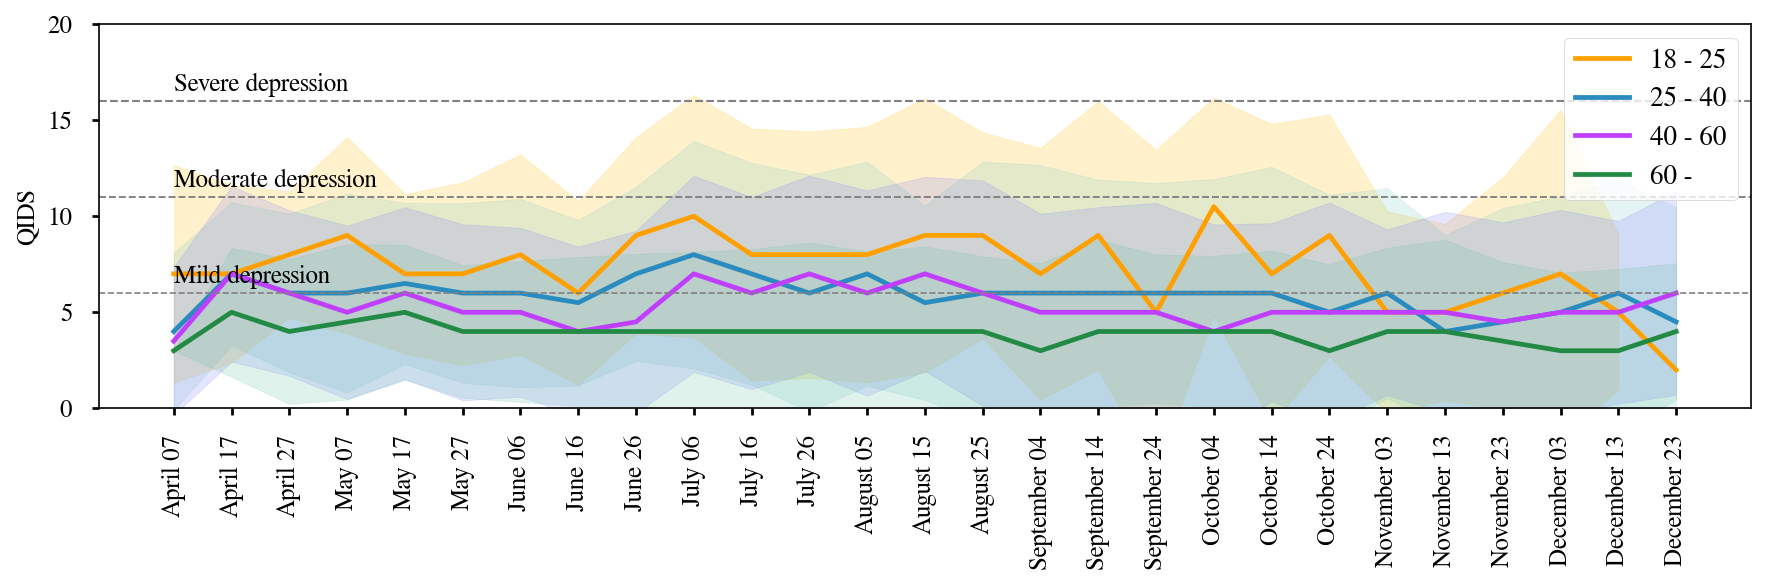

In [6]:
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['< 25'] == 1],
                                'qids', palette='Wistia', label='18 - 25')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['25 - 40'] == 1],
                                'qids', fig=fig, ax=ax, palette='GnBu', label='25 - 40')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['40 - 60'] == 1],
                                'qids', fig=fig, ax=ax, palette='cool', label='40 - 60')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['> 60'] == 1],
                                'qids', fig=fig, ax=ax, palette='BuGn', label='60 - ')

fontsize=12
# Add horizontal lines differentiating into various zones
plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
plt.annotate('Mild depression', xy=(init, 6.5), fontsize=fontsize)

plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
plt.annotate('Moderate depression', xy=(init, 11.5), fontsize=fontsize)

plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
plt.annotate('Severe depression', xy=(init, 16.5), fontsize=fontsize)
plt.ylim([0, 20])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc='upper right')
plt.ylabel('QIDS', fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/age_qids.pdf'%saveroot, bbox_inches='tight')
plt.show()

In [7]:
# Self reported mood
const = 60*60*24*10

qids_ids = [key for key in db if len(db[key]['news']) > 0 and\
            len(db[key]['A']) > 1]
            #db[key]['healthcare_worker']]

mood_dict = {key:db[key] for key in qids_ids}
print(len(mood_dict))

data_dict = {'mood': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             'country': [],
             'healthcare_worker': [],
             'camsr': [],
             #'compensation': [],
             'substance': [],
             'sleep_without_substance': [],
             'news_mental_health': [],
             '< 25': [],
             '25 - 40': [],
             '40 - 60': [],
             '> 60': []}

for key in mood_dict:
    A_panels = mood_dict[key]['A']
    physical = mood_dict[key]['pre_physical']
    mental = mood_dict[key]['pre_mental']
    
    camsr = float('Nan')
    for idx in range(10):
        if 'camsr%d'%idx in mood_dict[key]:
            camsr = mood_dict[key]['camsr%d'%idx]

    for A_panel in A_panels:
        time_stamp = const*(A_panel['timestamp']//const)
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        data_dict['mood'].append(A_panel['mood'])
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(mood_dict[key]['gender'])
        data_dict['country'].append(mood_dict[key]['country'])
        data_dict['healthcare_worker'].append(mood_dict[key]['healthcare_worker'])
        data_dict['camsr'].append(camsr)

        if 'news_mental_health' in A_panel:
            data_dict['news_mental_health'].append(A_panel['news_mental_health'])
        else:
            data_dict['news_mental_health'].append(float('nan'))
        if 'sleep_without_substance' in A_panel:
            data_dict['sleep_without_substance'].append(A_panel['sleep_without_substance'])
        else:
            data_dict['sleep_without_substance'].append(float('nan'))
        if 'substance' in A_panel:
            data_dict['substance'].append(A_panel['substance'])
        else:
            data_dict['substance'].append(float('nan'))
            
        if db[key]['age'] <= 25 :
            data_dict['< 25'].append(1)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 25 and\
        db[key]['age'] <= 40:     
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(1)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 40 and\
        db[key]['age'] <= 60:  
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(1)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 60 : 
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(1)

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')
print(data_pd.dropna().head())

566
      mood  nresponses     timestamp timestring timestring2  gender  \
6070     3           1  1.589760e+09      05 17      May 17  female   
6048     3           1  1.589760e+09      05 17      May 17    male   
6192     4           1  1.589760e+09      05 17      May 17    male   
6176     2           1  1.589760e+09      05 17      May 17  female   
6152     2           1  1.589760e+09      05 17      May 17  female   

                       country  healthcare_worker  camsr  substance  \
6070                    Ελλάδα                  0    3.0        1.0   
6048  United States of America                  1    3.0        0.0   
6192  United States of America                  0    4.0        0.0   
6176                    France                  0    3.0       -2.0   
6152  United States of America                  0    4.0       -2.0   

      sleep_without_substance  news_mental_health  < 25  25 - 40  40 - 60  \
6070                      0.0                 1.0     0        1 

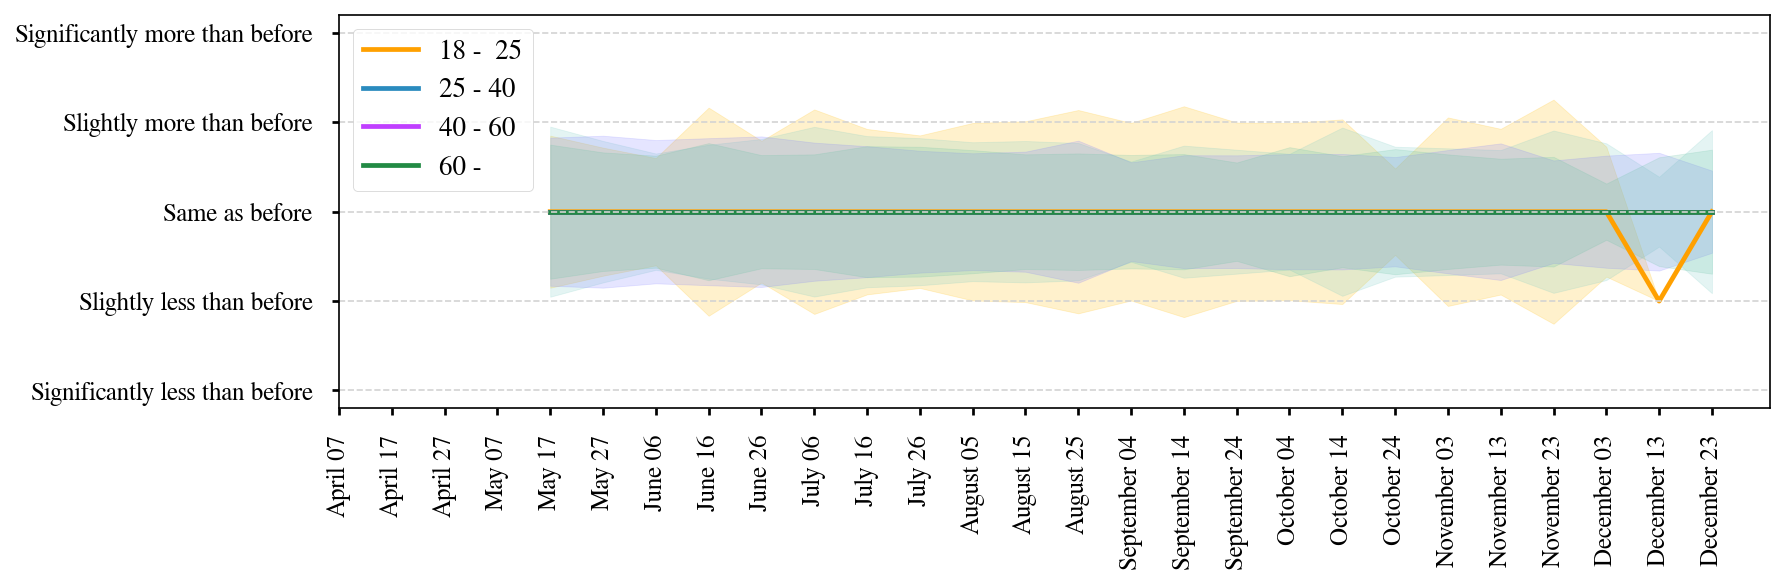

In [8]:
utils = importlib.reload(utils)
varname = 'mood'

fig, ax, init = utils.plot_timeseries(data_pd[data_pd['< 25'] == 1],
                                varname, palette='Wistia', label='18 -  25')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['25 - 40'] == 1],
                                varname, fig=fig, ax=ax, palette='GnBu', label='25 - 40')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['40 - 60'] == 1],
                                varname, fig=fig, ax=ax, palette='cool', label='40 - 60')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['> 60'] == 1],
                                varname, fig=fig, ax=ax, palette='BuGn', label='60 - ')

plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=3.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=4.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=5.0, linestyle='--', color='lightgray', linewidth=0.8)

plt.xticks(fontsize=fontsize)
plt.yticks([0, 1, 2, 3, 4, 5], ['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'], fontsize=fontsize)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('%s/%s_age.pdf'%(saveroot, varname))
plt.show()

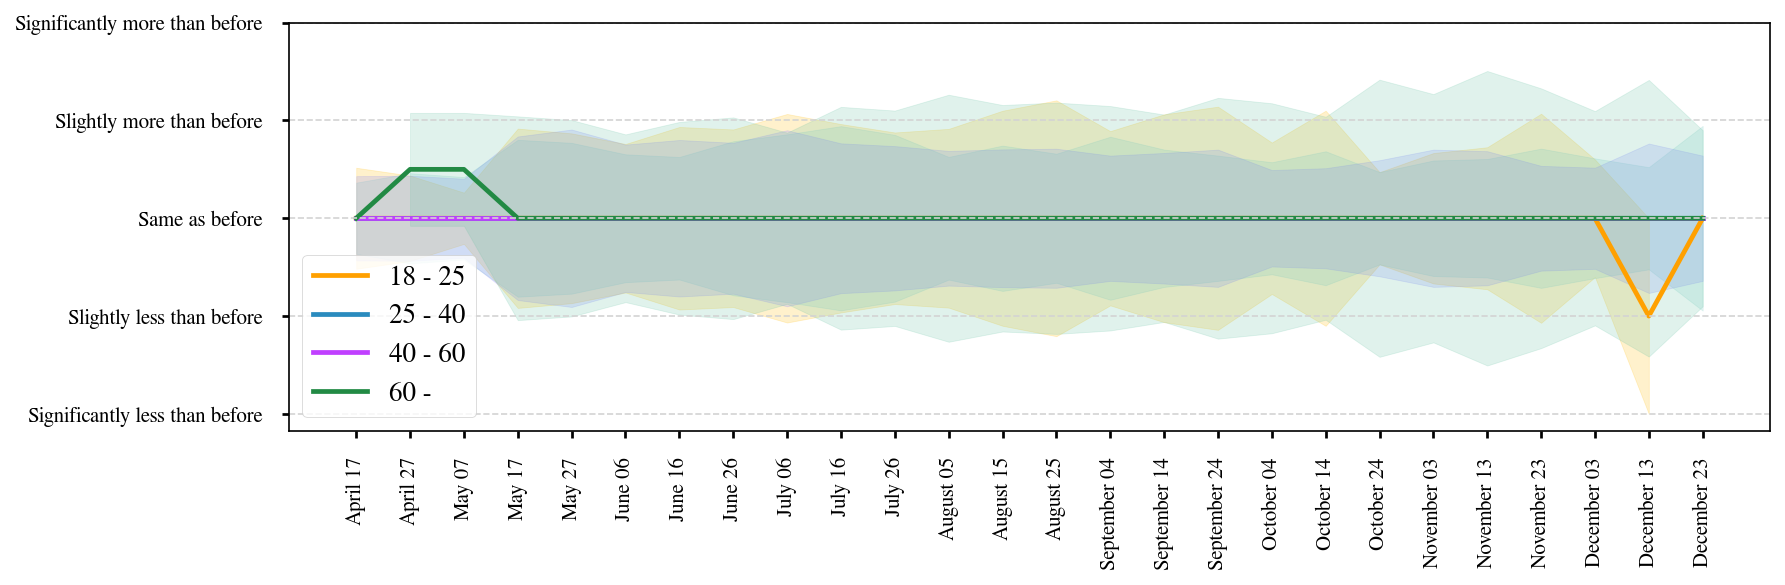

In [19]:
# Do a time series for news articles
const = 60*60*24*10
substance_gate = False

news_keys = [key for key in db if len(db[key]['news']) > 0]

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = int(datetime.date.today().strftime('%S'))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

data_dict = {'news': [],
             'news_accuracy': [],
             'news_stress': [],
             'news_mental_health': [],
             'news_adequate': [],
             'enjoy_present': [],
             'worried_about': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             'healthcare_worker': [],
             'timestamp': [],
             'nresponses': [],
             '< 25': [],
             '25 - 40': [],
             '40 - 60': [],
             '> 60': [],
             'country': [],
             'compensation': [],
             'substance': [],
             'sleep_without_substance': []}
dict_keys = ['news', 'news_accuracy', 'news_stress','news_mental_health',
             'enjoy_present', 'worried_about', 'news_adequate', 'substance',
             'sleep_without_substance']

for key in news_keys:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']
    for news_info in db[key]['news']:
        timestamp = const * (news_info['timestamp'] // const)
        for news_key in dict_keys:
            try:
                data_dict[news_key].append(news_info[news_key])
            except KeyError:
                data_dict[news_key].append(float('Nan'))
        
        if db[key]['age'] <= 25 :
            data_dict['< 25'].append(1)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 25 and\
        db[key]['age'] <= 40:     
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(1)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 40 and\
        db[key]['age'] <= 60:  
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(1)
            data_dict['> 60'].append(0)
        elif db[key]['age'] > 60 : 
            data_dict['< 25'].append(0)
            data_dict['25 - 40'].append(0)
            data_dict['40 - 60'].append(0)
            data_dict['> 60'].append(1)
            
        if 'healthcare_extra_compensation' in db[key]:
            data_dict['compensation'] = db[key]['healthcare_extra_compensation']
        else:
            data_dict['compensation'] = float('Nan')
            
        data_dict['nresponses'].append(1)
        data_dict['country'].append(db[key]['country'])
        data_dict['timestring'].append(d2s(timestamp*1000))
        data_dict['timestring2'].append(d2s2(timestamp*1000))
        data_dict['gender'].append(db[key]['gender'])
        data_dict['healthcare_worker'].append(db[key]['healthcare_worker'])
        data_dict['timestamp'].append(timestamp)

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')


if substance_gate:
    thres = 0
    affix = 'substance_gate'
else:
    thres = 10
    affix = 'full'

varname = 'sleep_without_substance'
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['< 25'] == 1)*(data_pd['substance'] != thres)],
                                varname, palette='Wistia', label='18 - 25')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['25 - 40'] == 1)*(data_pd['substance'] != thres)],
                                varname, fig=fig, ax=ax, palette='GnBu', label='25 - 40')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['40 - 60'] == 1)*(data_pd['substance'] != thres)],
                                varname, fig=fig, ax=ax, palette='cool', label='40 - 60')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['> 60'] == 1)*(data_pd['substance'] != 0)],
                                varname, fig=fig, ax=ax, palette='BuGn', label='60 - ')

plt.legend(loc='lower left')
if varname == 'news_mental_health':
    plt.yticks([0, 1, 2, 3], labels=['Not at all', 'Mildly', 'Moderately', 'Very significantly'])
    #plt.ylabel('News affecting mental health')

    plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=3.0, linestyle='--', color='lightgray', linewidth=0.8)
elif varname == 'substance' or varname == 'sleep_without_substance':
    plt.yticks([-2, -1, 0, 1, 2], labels=['Significantly less than before',
                                          'Slightly less than before',
                                          'Same as before', 
                                          'Slightly more than before', 
                                          'Significantly more than before'])

    plt.axhline(y=-2.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=-1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=0.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)

plt.tight_layout()
plt.savefig('%s/age_%s_%s.pdf'%(saveroot, affix, varname), bbox_inches='tight')
plt.show()